In [1]:
import numpy as np
import pandas as pd
from keras.models import load_model
from math import pi
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from pandas import DataFrame

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


<h1>Load Model</h1>

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.loc[:, self.columns]
    
class YearExtractor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.applymap(lambda x: float(pd.to_datetime(x).year))

class CosExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.unique = X.nunique()
        return self
        
    def transform(self, X, y=None):
        return X.apply(lambda x: np.round(np.cos(x * pi * 2/ self.unique), 5), axis=1)

class SinExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.unique = X.nunique()
        return self
        
    def transform(self, X, y=None):
        return X.apply(lambda x: np.round(np.sin(x * pi * 2/ self.unique), 5), axis=1)

In [13]:
xg = joblib.load('./model/xg.pkl')
all_pipeline = joblib.load('./model/all_pipeline.pkl')
time_pipeline = joblib.load('./model/time_pipeline.pkl')
model = load_model('./model/dl.h5')

<h1>Load Data</h1>

In [3]:
data = pd.read_csv('./historic_data.csv')

train_cut = int(len(data) * 0.8)
validate_cut = int(len(data) * 0.9)
test_cut = int(len(data))

data['actual'] = data['rides']
data['lag7'] = data['rides'].shift(7*24)
data['lag1'] = data['rides'].shift(2*24)

In [4]:
data.head()

,date,hour,month,day_of_week,sunrise,icon,precip_prob,temperature,humidity,wind_speed,rides,actual,lag7,lag1
0,2013-06-01,0,6,7,0,clear,0.01,77.65,0.61,2.06,152,152,NaN,NaN
1,2013-06-01,1,6,7,0,clear,0.01,75.62,0.67,1.93,102,102,NaN,NaN
2,2013-06-01,2,6,7,0,clear,0.01,74.72,0.70,2.31,67,67,NaN,NaN
3,2013-06-01,3,6,7,0,clear,0.01,73.32,0.76,2.16,41,41,NaN,NaN
4,2013-06-01,4,6,7,0,clear,0.01,72.42,0.79,1.93,16,16,NaN,NaN


<h1>XG Prediction</h1>

In [45]:
xg_preds = xg.predict(data.iloc[validate_cut:test_cut, :])
mean_squared_error(xg_preds, data.iloc[validate_cut:test_cut, 11])

211764.25410673942

<h1>DL Prediction</h1>

In [50]:
def create_datasets(time_X, all_X, start=0, stop=len(time_X)+1):
    ONE_DAY = 24
    lookback = 28*ONE_DAY 
    lag = 2*ONE_DAY 
    
    if start < lookback + lag:
        start = lookback + lag

    input_time_X = np.zeros((stop-start, lookback//ONE_DAY, len(time_X[0])))
    input_all_X = np.zeros((stop-start, len(all_X[0])))
    
    for i in range(start, stop):
        input_time_X[i-start] = time_X[i-lookback-lag:i-lag:ONE_DAY]
        input_all_X[i-start] = all_X[i]
    
    return [input_time_X, input_all_X]

In [51]:
all_X = all_pipeline.transform(data)
time_X = time_pipeline.transform(data)

dl_preds = model.predict(create_datasets(time_X, all_X, validate_cut, test_cut))
mean_squared_error(dl_preds[:, 0], data.iloc[validate_cut:test_cut, 11])


282973.17653955234

<h1>Ensemble Model</h1>

In [52]:
predictions = (xg_preds + dl_preds[:, 0]) / 2
predictions[0:5]

array([  96.74913,  168.27386,  326.7422 ,  788.2599 , 1834.177  ],
      dtype=float32)

In [54]:
mean_squared_error(predictions, data.iloc[validate_cut:test_cut, 11])

183583.94698218492

<h1>Examination</h1>

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ['R_HOME'] = r'C:\Program Files\R\R-3.4.4'

%matplotlib inline
%load_ext rpy2.ipython

In [56]:
%%R
install.packages('tidyverse')
library(tidyverse)

In [59]:
explore = DataFrame({'date': data.iloc[validate_cut:test_cut, 0], 
                     'rides': data.iloc[validate_cut:test_cut, 11], 
                     'preds': predictions})

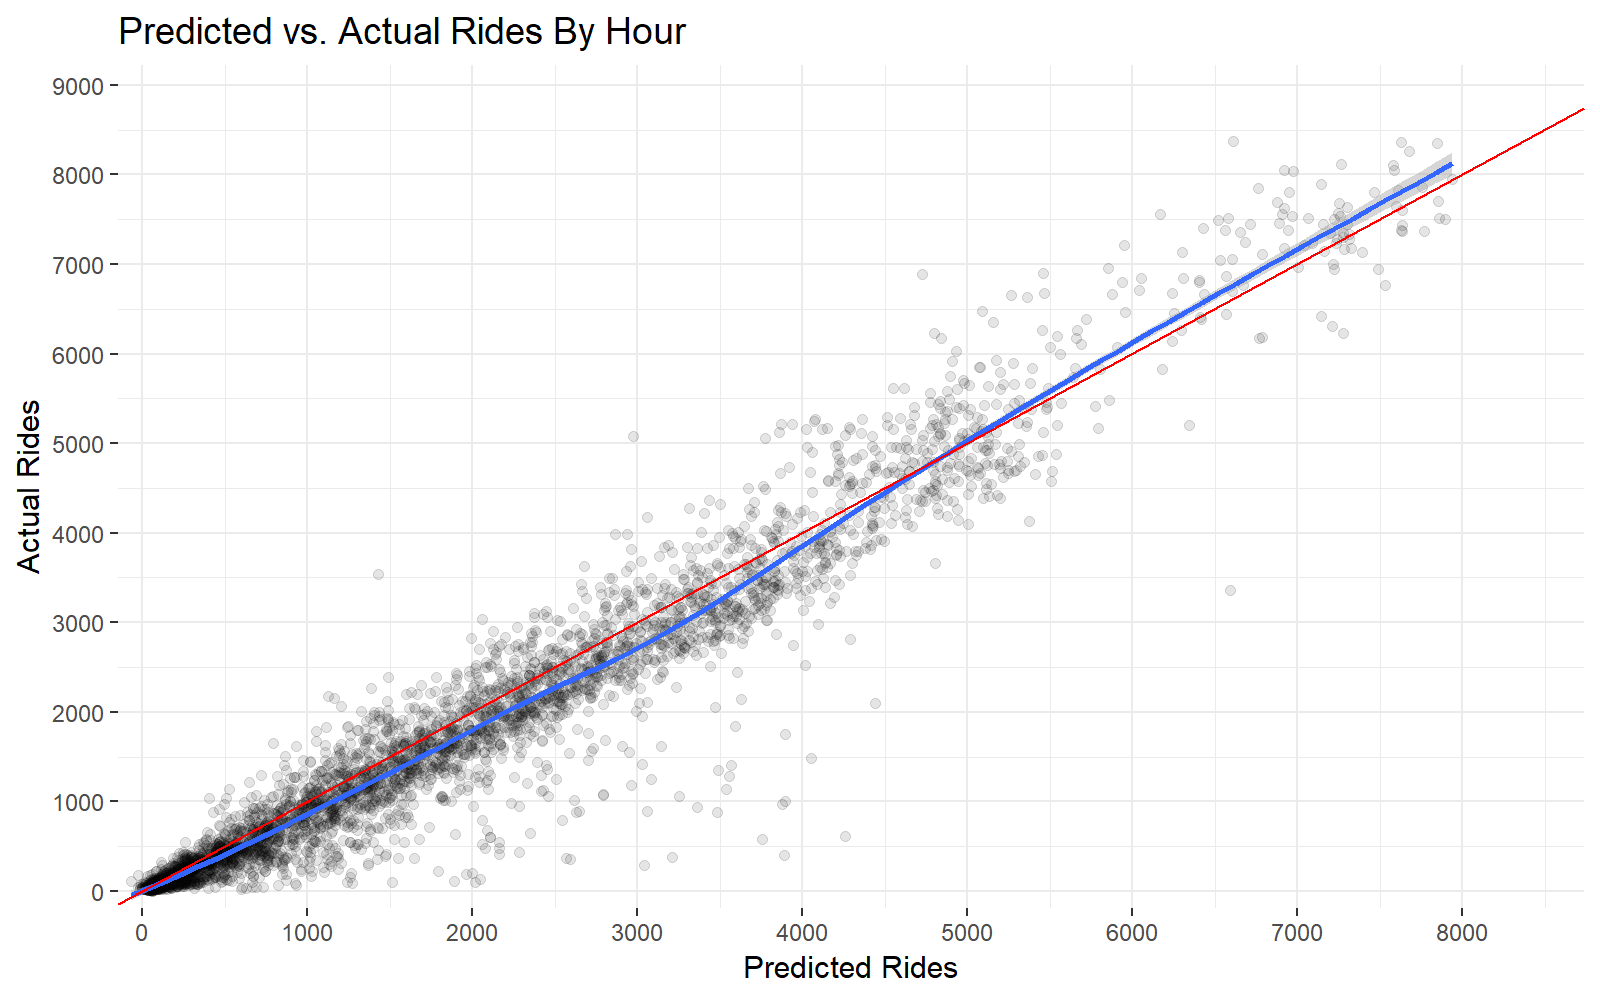

In [65]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  ggplot(aes(preds, rides)) +
  geom_point(alpha=0.1) +
  geom_smooth() +
  geom_abline(slope=1, intercept=0, color='red') +
  labs(x='Predicted Rides',
       y='Actual Rides',
       title='Predicted vs. Actual Rides By Hour') + 
  scale_x_continuous(labels=seq(0, 9000, 1000), breaks=seq(0, 9000, 1000), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(labels=seq(0, 9000, 1000), breaks=seq(0, 9000, 1000), expand=c(0.01, 0.1, 0.1, 0)) +
  theme_bw() +
  theme(panel.border = element_blank())
  

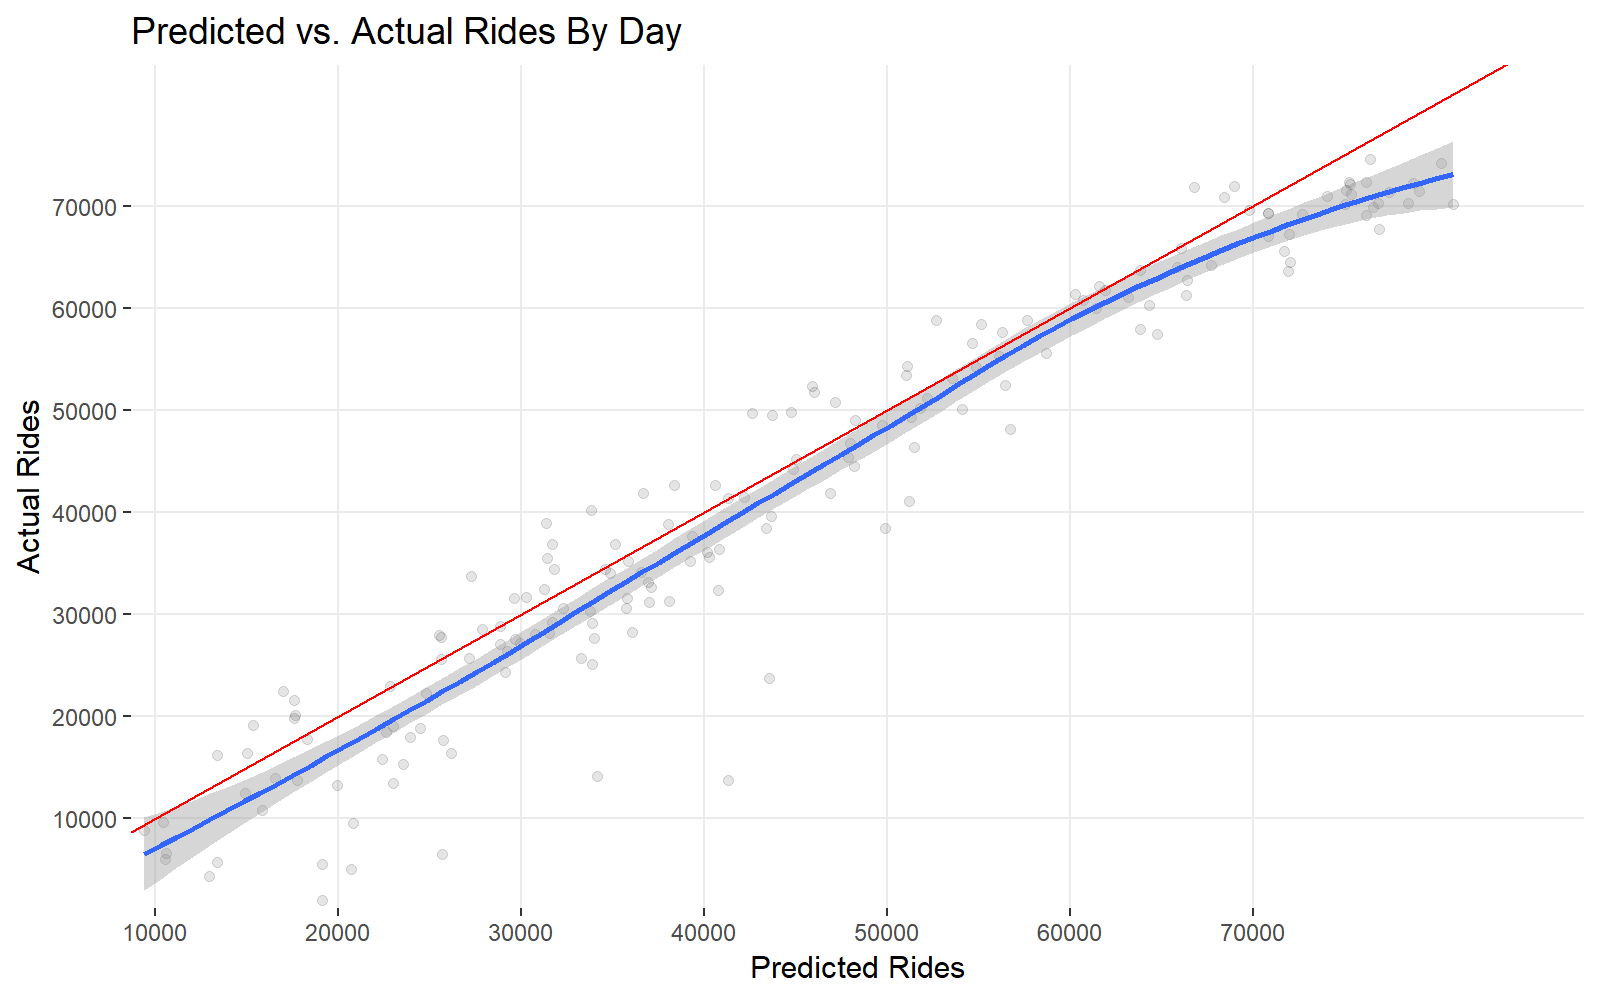

In [66]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  group_by(date) %>%
  summarize(preds = sum(preds),
            rides = sum(rides)) %>%
  ggplot(aes(preds, rides)) +
  geom_point(alpha=0.1) +
  geom_smooth() +
  geom_abline(slope=1, intercept=0, color='red') +
  labs(x='Predicted Rides',
       y='Actual Rides',
       title='Predicted vs. Actual Rides By Day') + 
  scale_x_continuous(labels=seq(0, 70000, 10000), breaks=seq(0, 70000, 10000), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(labels=seq(0, 70000, 10000), breaks=seq(0, 70000, 10000), expand=c(0.01, 0.1, 0.1, 0)) +
  theme_bw() +
  theme(panel.border = element_blank(),
        panel.grid.minor = element_blank())
  

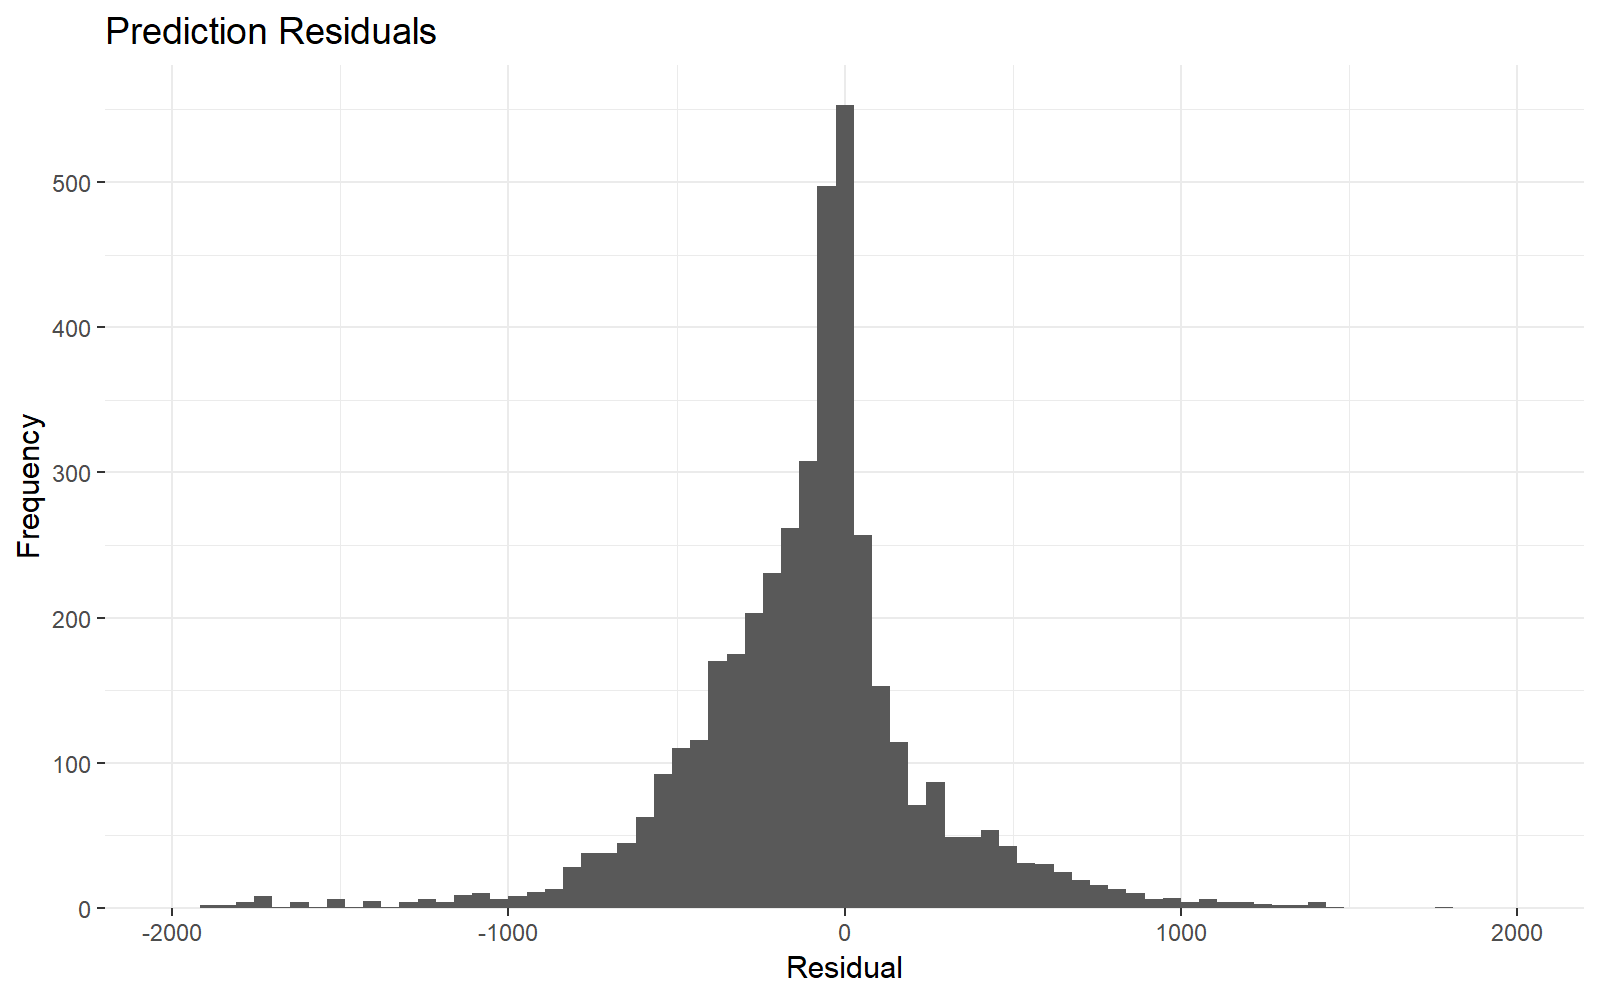

In [67]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  mutate(resid = rides - preds) %>%
  ggplot(aes(resid)) +
  geom_histogram(bins=75) +
  labs(x='Residual',
       y='Frequency',
       title='Prediction Residuals') +
  scale_x_continuous(labels=seq(-2000, 2000, 500), breaks=seq(-2000, 2000, 500), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(expand=c(0, 0, 0.05, 0)) +
  xlim(-2000, 2000) +
  theme_bw() +
  theme(panel.border = element_blank())
  